# Load libraries, define constants, functions, and classes

* libraries

in order to get tensorrt_libs to install and not give an error w.r.t version-ing

https://github.com/NVIDIA/TensorRT/issues/2933

In [1]:
import os

import sys
sys.path.append("../2_train_and_test_models")

import tensorflow
from tensorflow.keras import Input, Model
from tensorflow.keras.utils import Sequence
from tensorflow.keras.layers import Dense, Dropout, Activation, LSTM, Conv1D, MaxPooling1D, Reshape
tensorflow.random.set_seed(42)

import numpy as np
np.random.seed(42)

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

from params import ROOT, GENOMES, Params
from seqdataloader.batchproducers.coordbased.core import Coordinates
from seqdataloader.batchproducers.coordbased.coordstovals.fasta import PyfaidxCoordsToVals
from collections import defaultdict
from math import ceil
from sklearn.metrics import mean_absolute_error
from scipy.stats import wilcoxon
from collections import defaultdict

np.random.seed(42)
tensorflow.random.set_seed(42)

2025-03-06 20:22:39.975384: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-06 20:22:39.995980: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741310560.016901 3371934 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741310560.023283 3371934 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-06 20:22:40.044705: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

* constants

In [2]:
SEQ_LEN     = 500
NUM_SEQS    = 2000
SAVE        = True
SPECIES     = ["mm10", "hg38"]
TFS         = ["CTCF", "CEBPA", "HNF4A", "RXRA"]

SPECIES1    = "hg38"
SPECIES2    = "mm10"

# Shorthand names for all model types to include in plots
MODELS = [
    "BM",
    "GRL",
    "MORALE"
]

# Plot-acceptable names for model types
MODEL_NAMES = {
    "BM-mm10": "Mouse-trained",
    "BM-hg38": "Human-trained",
    "GRL-mm10": "Mouse-trained\n(+GRL)",
    "GRL-hg38": "Human-trained\n(+GRL)",
    "MORALE-mm10": "Mouse-trained\n(+MORALE)",
    "MORALE-hg38": "Human-trained\n(+MORALE)"
}

ATTR_SITES      = ["dFP", "dFN"]
SITES_TO_PLOT   = ["dFP", "dFN", ["dFP", "dFN"]]
SITE_ORDER      = ["dFP", "dFN", "Mix"]

* Helper functions to use

In [3]:
def get_preds_file(model, tf, source_species, domain):
    preds_root = f"{ROOT}/output"
    os.makedirs(preds_root, exist_ok=True)
    return f"{preds_root}/{model}_tf-{tf}_trained-{source_species}_tested-{domain}.preds.npy"

def get_labels_file(model, tf, source_species, domain):
    preds_root = f"{ROOT}/output"
    os.makedirs(preds_root, exist_ok=True)
    return f"{preds_root}/{model}_tf-{tf}_trained-{source_species}_tested-{domain}.labels.npy"

def load_fivefold_data(average=False, verbose=False):
    preds_dict      = defaultdict(lambda : defaultdict(lambda : dict()))
    labels_dict     = defaultdict(lambda : defaultdict(lambda : dict()))
    bound_indices   = defaultdict(lambda : defaultdict(lambda : dict()))
    unbound_indices = defaultdict(lambda : defaultdict(lambda : dict()))

    # Loop over mouse-trained, human-trained models, and domain-adaptive models
    for model in MODELS:
        for tf in TFS:
            for source in SPECIES:
                for target in SPECIES:
                    if verbose:
                        print(f"\t({model} on {tf} when: {source}-trained, and {target}-tested)")
                    preds_file  = get_preds_file(model=model, tf=tf, source_species=source, domain=target)
                    labels_file = get_labels_file(model=model, tf=tf, source_species=source, domain=target)
                
                    try:
                        # Load them
                        preds = np.load(preds_file)
                        labels = np.load(labels_file)

                        # Calculate if we need to truncate the labels
                        if preds.shape[0] != labels.shape[0]:
                            print("\nTruncating labels\n")
                            labels = labels[:preds.shape[0]]

                        assert preds.shape[0] == labels.shape[0]

                        if average:
                            # We take the average of the sigmoid values across the five-folds
                            # to determine the confusion matrix
                            preds_dict[f"{model}-{source}"][tf][target] = np.mean(preds, axis=1)
                        else:                        
                            # We save predictions from each of the five-folds per model, TF, source, and target
                            preds_dict[f"{model}-{source}"][tf][target] = np.load(preds_file)
                        
                        labels_dict[f"{model}-{source}"][tf][target] = np.load(labels_file)

                        # Store unbound and bound indices for all models, TFs, sources, and targets
                        bound_indices[f"{model}-{source}"][tf][target]      = np.nonzero(labels == 1)[0]
                        unbound_indices[f"{model}-{source}"][tf][target]    = np.nonzero(labels == 0)[0]
                        
                    except:
                        print("Could not load regular preds/labels files")

    return preds_dict, labels_dict, bound_indices, unbound_indices

def generate_confusion_matrix(verbose=False):
    """
    This function categorizes sites in the test set as being
    TNs, FPs, TPs, or FNs, recording the index of each site for 
    each category. We will do this for every TF/training-species combo
    (assuming the sites we're looking at are all from the same genome)

    We have five-folds of performance, so what we do is calculate the confusion
    matrix for each fold, and then average the results. We report the confusion
    matrix as the average of the five confusion matrices.
    """

    # (1) Load the predictions, labels, and bound/unbound indices
    print("\n=== Loading the predictions, labels, and bound/unbound indices ===\n")
    preds_dict, _, bound_indices, unbound_indices = load_fivefold_data(average=True, verbose=verbose)
    
    # Indices we need to populate
    tp_indices = defaultdict(lambda: defaultdict(lambda: {}))
    fp_indices = defaultdict(lambda: defaultdict(lambda: {}))
    tn_indices = defaultdict(lambda: defaultdict(lambda: {}))
    fn_indices = defaultdict(lambda: defaultdict(lambda: {}))

    # (2) Generate the confusion matrix
    print("\n=== Generating TPs, FPs, TNS, and FNs by looking at bound/unbound sites (in comparison to the predictions) ===\n")
    for model in MODELS:
        for tf in TFS:
            for source in SPECIES:
                for target in SPECIES:
                    
                    model_name= f"{model}-{source}"

                    if verbose:
                        print(f"\t({model} for tf-{tf}, source-{source}, target-{target})")

                    # We use <= 0.5 to classify as unbound 
                    bound_predictions_indices       = np.where(preds_dict[model_name][tf][target] > 0.5)[0]
                    unbound_predictions_indices     = np.where(preds_dict[model_name][tf][target] <= 0.5)[0]

                    # We store these for each example, but they will be constant across target-tfs pairs
                    ground_truth_bound_indices      = bound_indices[model_name][tf][target]
                    ground_truth_unbound_indices    = unbound_indices[model_name][tf][target]

                    # For each example the models predicted as bound...
                    tp_indices[model_name][tf][target] = set(bound_predictions_indices).intersection(set(ground_truth_bound_indices))
                    fp_indices[model_name][tf][target] = set(bound_predictions_indices).intersection(set(ground_truth_unbound_indices))

                    # For each example the models predicted as bound...
                    tn_indices[model_name][tf][target] = set(unbound_predictions_indices).intersection(set(ground_truth_unbound_indices))
                    fn_indices[model_name][tf][target] = set(unbound_predictions_indices).intersection(set(ground_truth_bound_indices))
                
    return preds_dict, tp_indices, fp_indices, tn_indices, fn_indices

def get_site_indices(species_1, species_2, verbose=False):
    """ 
    This function uses the predictions and binding labels for
    all sites in the test set to determine if sites are
    both-model false positives, false negatives, mouse-model FPs, etc.
    
    Here we use a definition of "differentially predicted site"
    to find mouse-model FPs or FNs that requires the difference
    between the mouse-model prediction and the human-model prediction
    to be at least 0.5
    """

    assert species_1 != species_2, "Species 1 and Species 2 must be different"
    assert species_1 in SPECIES, f"Species 1 must be one of {SPECIES}"
    assert species_2 in SPECIES, f"Species 2 must be one of {SPECIES}"

    preds_dict, tp_indices, fp_indices, tn_indices, fn_indices = generate_confusion_matrix(verbose=verbose)
        
    site_indices = defaultdict(lambda : dict())

    for tf in TFS:
        # If the site classification agrees for both the 'lower' and 'upper' bound, our domain adaptive models should get it right
        site_indices[tf]["bothTP"] = tp_indices[f"BM-{species_1}"][tf][species_2].intersection(tp_indices[f"BM-{species_2}"][tf][species_2])
        site_indices[tf]["bothFP"] = fp_indices[f"BM-{species_1}"][tf][species_2].intersection(fp_indices[f"BM-{species_2}"][tf][species_2])
        site_indices[tf]["bothFN"] = fn_indices[f"BM-{species_1}"][tf][species_2].intersection(fn_indices[f"BM-{species_2}"][tf][species_2])
        site_indices[tf]["bothTN"] = tn_indices[f"BM-{species_1}"][tf][species_2].intersection(tn_indices[f"BM-{species_2}"][tf][species_2])

        # Now we need to look at sites that are only correctly classified by either the 'lower' or 'upper' bound model
        species_1_overpredicted  = set(np.where(preds_dict[f"BM-{species_1}"][tf][species_2] - preds_dict[f"BM-{species_2}"][tf][species_2] > 0.5)[0])
        species_1_underpredicted = set(np.where(preds_dict[f"BM-{species_2}"][tf][species_2] - preds_dict[f"BM-{species_1}"][tf][species_2] > 0.5)[0])

        site_indices[tf]["dTP"] = tp_indices[f"BM-{species_1}"][tf][species_2].intersection(species_1_overpredicted)
        site_indices[tf]["dFP"] = fp_indices[f"BM-{species_1}"][tf][species_2].intersection(species_1_overpredicted)
        site_indices[tf]["dFN"] = fn_indices[f"BM-{species_1}"][tf][species_2].intersection(species_1_underpredicted)
        site_indices[tf]["dTN"] = tn_indices[f"BM-{species_1}"][tf][species_2].intersection(species_1_underpredicted)

    return site_indices

In [4]:
'''
From Keras:

Weights are loaded based on the network's topology. This means the architecture should be the same as when the weights were saved.
Note that layers that don't have weights are not taken into account in the topological ordering, so adding or removing layers is 
fine as long as they don't have weights.

We redefine our models so that we can use it with tf 2.18.0; for example
we remove the MomentAlignmentLayer and just use the in our model. There are
no weights to load, so we don't need to worry about that.
'''
def basic_model(params):
	# Inputs
	seq_input	= Input(shape = (params.seqlen, 4, ))
	# index		= Input(shape = (1,), name = 'index') # we don't use this here

	# Basic, CNN model
	seq = Conv1D(params.convfilters, params.filtersize, padding = "same")(seq_input)
	seq = Activation("relu")(seq)
	seq = MaxPooling1D(padding = "same", strides = params.strides, pool_size = params.pool_size)(seq)
	seq = LSTM(params.lstmnodes)(seq)
	seq = Dense(params.dl1nodes, activation = "relu")(seq)
	seq = Dropout(params.dropout)(seq)
	seq = Dense(params.dl2nodes, activation = "sigmoid")(seq)
	seq = Dense(1)(seq)

	# Label
	result = Activation("sigmoid")(seq)

	return Model(inputs = seq_input, outputs = result, name = "BM")

def GRL(params, lambda_=1.0):
	# Here we specify the architecture of the domain-adaptive model.

	# Inputs
	seq_input	= Input(shape = (params.seqlen, 4, ))
	# index		= Input(shape = (1,), name = 'index')

	# Shared convolutional layer
	seq = Conv1D(params.convfilters, params.filtersize, padding="same")(seq_input)
	seq = Activation('relu')(seq)
	seq = MaxPooling1D(padding = "same", strides = params.strides, pool_size = params.pool_size)(seq)

	# Classifier technically includes the LSTM layer (from Cochran et al.)
	classifier		= LSTM(params.lstmnodes)(seq)
	classifier		= Dense(params.dl1nodes)(classifier)
	classifier		= Activation('relu')(classifier)
	classifier		= Dense(params.dl2nodes, activation = 'sigmoid')(classifier)
	class_result	= Dense(1, activation = 'sigmoid', name = "classifier")(classifier)

	# Discriminator acts upon 
	discriminator	= Reshape((params.get_reshape_size(), ))(seq)
	#discriminator	= GradientReversal(lambda_)(discriminator)
	discriminator	= Dense(params.dl1nodes)(discriminator)
	discriminator	= Activation('relu')(discriminator)
	discriminator	= Dense(params.dl2nodes, activation = 'sigmoid')(discriminator)
	disc_result		= Dense(1, activation = 'sigmoid', name = "discriminator")(discriminator)

	model = Model(inputs = seq_input, outputs = [class_result, disc_result], name = "GRL")
	return model

def MORALE(params):
    # Inputs
    seq_input	= Input(shape = (params.seqlen, 4,))
    # index		= Input(shape = (), name='index')

    # To the embedding of the sequence
    seq         = Conv1D(params.convfilters, params.filtersize, padding = "same")(seq_input)
    seq         = Activation("relu")(seq)
    seq         = MaxPooling1D(padding = "same", strides = params.strides, pool_size = params.pool_size)(seq)
    embedding   = LSTM(params.lstmnodes)(seq)

    # Continue with the model, specifying the architecture for binding label prediction
    seq		= Dense(params.dl1nodes, activation = "relu")(embedding)
    seq		= Dropout(params.dropout)(seq)
    seq		= Dense(params.dl2nodes, activation = "sigmoid")(seq)
    seq		= Dense(1)(seq)
    result	= Activation("sigmoid")(seq)

    model = Model(inputs = seq_input, outputs = result, name = "MORALE")
    #model = Model(inputs = [seq_input, index], outputs = result, name = "MORALE")
    
    return model

def get_model_file(model, tf, source_species, run):
    # This function returns the filepath where the model for a given
    # TF, training species, and run is saved.
    # By default, the file for the best model across all training epochs
    # is returned, you can change model_type to select the last model instead.
    # This function specifically looks for the most recent model file,
    # if there are multiple for the same run-TF-species combo.

    assert model in MODELS, f"Model must be one of {MODELS}"

    try:
        run_int = int(run)
    except:
        print("Error: You need to pass in a run number that can be cast to int.")

    model_file_prefix = f"{ROOT}/models/{tf}/{source_species}_trained/{model}"
    model_file_suffix = f"_run{str(run)}.weights.h5"
    
    # Get all files that match the prefix and suffix
    files = [f for f in os.listdir(model_file_prefix) if f.endswith(model_file_suffix)]
    
    # sort files and return the one that is most recent
    latest_file = max([f"{model_file_prefix}/{f}" for f in files], key=os.path.getctime)
    return latest_file

def load_keras_model(model, tf, source_species, run, model_file):

    assert model in MODELS, f"Model must be one of {MODELS}"

    params  = Params(["Attribution", tf, source_species, run], verbose=False)

    # Load based on model type
    if model == "BM":
        model = basic_model(params)
    elif model == "MORALE":
        model = MORALE(params)
    elif model == "GRL":    
        model = GRL(params)

    model.load_weights(model_file, skip_mismatch=False)

    return model

def get_models_all_runs(runs=5):
    saved_models = defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: [])))
    
    for model in MODELS:
        for tf in TFS:
            for source in SPECIES:
                for target in SPECIES:
                    for run in range(runs):
                        model_file = get_model_file(model=model, tf=tf, source_species=source, run=run+1)
                        print("Loading model from:", model_file)
                        saved_models[f"{model}-{source}"][tf][target].append(load_keras_model(model=model, tf=tf, source_species=source, run=run, model_file=model_file))
            
    return saved_models

In [5]:
def get_creasted_contributions(intervals, saved_model, genome):
    """
    Computes DeepLIFT attributions using SHAP(ley) values!

    Args:
        gen_dict: A dictionary of generators.
        model: The (TensorFlow) model.
        background_dataset: A background dataset (numpy array) to use for DeepLIFT.
        num_seqs_to_do: Optional number of sequences to process.

    Returns:
        A dictionary of attribution scores.
    """
    import crested
    from crested.tl import contribution_scores

    scores, one_hot_encoded_sequences = contribution_scores(
        input=intervals,
        target_idx=None,
        model=saved_model,
        method='expected_integrated_grad',
        genome=GENOMES[genome],
        transpose=True,
        output_dir=None,
        verbose=True
    )

    return scores, one_hot_encoded_sequences

def read_holdout_bed(tf, species, site_indices):
    
    # Read holdout bed file
    holdout_bed_path = f"{ROOT}/data/{species}/{tf}/chr2.bed"
    holdout_bed = pd.read_csv(holdout_bed_path, sep="\t", names=['chrom', 'start', 'end', 'label'], usecols=['chrom','start','end'])

    # Only keep the extreme agreement sites
    holdout_bed = holdout_bed.iloc[list(site_indices)]

    # Create the necessary strings for the regions we need
    chrom_values = holdout_bed.iloc[:, 0]
    start_values = holdout_bed.iloc[:, 1]
    end_values = holdout_bed.iloc[:, 2]

    # Create the region strings
    regions = [
        f"{chrom}:{start}-{end}"
        for chrom, start, end in zip(chrom_values, start_values, end_values)
    ]

    shuffled_indices = np.random.permutation(len(regions))[:2000]
    regions = [regions[i] for i in shuffled_indices]

    return regions

In [6]:
def normalize_by_quantile(profiles, quantile=0.9):
    """Normalizes each profile in a matrix by its specified quantile."""
    if not isinstance(profiles, np.ndarray):
        raise TypeError("Input must be a NumPy array.")

    if profiles.ndim != 2:
        raise ValueError("Input must be a 2D array (matrix).")

    normalized_profiles = np.zeros_like(profiles, dtype=float)  # Pre-allocate

    for i in range(profiles.shape[0]):  # Iterate over rows (profiles)
        profile = profiles[i, :]  # Extract a single profile (row)
        abs_profile = np.abs(profile)
        norm = np.quantile(abs_profile, quantile)

        if norm == 0:
            normalized_profiles[i, :] = profile  # Keep original if norm is zero
        else:
            normalized_profiles[i, :] = profile / norm

    return np.array(normalized_profiles)

def calculate_distances(ground_truth, morale_importance, grl_importance, linear_transform=True):
    """Calculates L1 distance, Normalized L1 distance, and correlation."""

    # Ensure numpy arrays
    ground_truth        = np.array(ground_truth)
    morale_importance   = np.array(morale_importance)
    grl_importance      = np.array(grl_importance)

    # Calculate -np.log2(L1 distances)
    l1_distance_morale  = -np.log2(np.abs(ground_truth - morale_importance)).flatten()
    l1_distance_grl     = -np.log2(np.abs(ground_truth - grl_importance)).flatten()

    # Normalize profiles at the 90th percentile
    ground_truth_norm       = normalize_by_quantile(ground_truth)
    morale_importance_norm  = normalize_by_quantile(morale_importance)
    grl_importance_norm     = normalize_by_quantile(grl_importance)

    # Calculate normalized L1 distances
    norm_l1_distance_morale = -np.log2(np.abs(ground_truth_norm - morale_importance_norm)).flatten()
    norm_l1_distance_grl    = -np.log2(np.abs(ground_truth_norm - grl_importance_norm)).flatten()

    # Calculate R^{2}
    if linear_transform:
        from sklearn.preprocessing import StandardScaler
        from sklearn.model_selection import GridSearchCV
        from sklearn import linear_model, kernel_ridge
        from scipy.stats import pearsonr

        # Normalize the importance scores
        scaler = StandardScaler()
        morale_importance_scaled    = scaler.fit_transform(morale_importance)
        grl_importance_scaled       = scaler.fit_transform(grl_importance)

        # Split into test and train
        n_train     =  morale_importance_scaled.shape[0] // 2

        morale_importance_scaled_train  = morale_importance_scaled[:n_train, :]
        morale_importance_scaled_test   = morale_importance_scaled[n_train:, :]

        grl_importance_scaled_train     = grl_importance_scaled[:n_train, :]
        grl_importance_scaled_test      = grl_importance_scaled[n_train:, :]

        ground_truth_train  = ground_truth[:n_train, :]
        ground_truth_test   = ground_truth[n_train:, :]

        # model = GridSearchCV(
        #     kernel_ridge.KernelRidge(kernel='rbf', gamma=0.1),
        #     param_grid={"alpha": [1e0, 0.1, 1e-2, 1e-3], "gamma": np.logspace(-2, 2, 4)},
        #     cv=2,
        #     n_jobs=-1,
        #     verbose=3
        # )
        # model.fit(morale_importance_scaled_train, ground_truth_train)
        # morale_importance_pred  = model.predict(morale_importance_scaled_test)

        model_morale = linear_model.LinearRegression()
        model_grl    = linear_model.LinearRegression()

        model_morale.fit(morale_importance_scaled_train, ground_truth_train)
        model_grl.fit(grl_importance_scaled_train, ground_truth_train)

        morale_importance_pred = model_morale.predict(morale_importance_scaled_test)
        grl_importance_pred    = model_grl.predict(grl_importance_scaled_test)

        # correlation_morale  = r2_score(ground_truth_test, morale_importance_pred, multioutput='raw_values')
        # correlation_grl     = r2_score(ground_truth_test, grl_importance_pred, multioutput='raw_values')

        correlation_morale, _  = pearsonr(ground_truth_test, morale_importance_pred)
        correlation_grl, _     = pearsonr(ground_truth_test, grl_importance_pred)
    else:
        correlation_morale  = r2_score(ground_truth, morale_importance, multioutput='raw_values')
        correlation_grl     = r2_score(ground_truth, grl_importance, multioutput='raw_values')

    # Calculate Mean Squared Error
    mse_morale  = mean_squared_error(ground_truth, morale_importance, multioutput='raw_values')
    mse_grl     = mean_squared_error(ground_truth, grl_importance, multioutput='raw_values')

    return {
        "MORALE": {
            "l1": l1_distance_morale,
            "normalized_l1": norm_l1_distance_morale,
            "correlation": correlation_morale,
            "mse": mse_morale
        },
        "GRL": {
            "l1": l1_distance_grl,
            "normalized_l1": norm_l1_distance_grl,
            "correlation": correlation_grl,
            "mse": mse_grl,
        }
    }

def plot_importance_differences(importance_model_1, importance_model_2, sequence):
    """Plots the difference in importance scores between two models along the sequence."""
    importance_diff = importance_model_1 - importance_model_2

    fig, ax = plt.subplots(figsize=(12, 4))

    sns.heatmap(
        [importance_diff],
        cmap='coolwarm',
        center=0,
        annot=False,
        xticklabels=list(sequence),
        cbar_kws={'label': 'Importance Score Difference (Model 1 - Model 2)'}
    )

    ax.set_title('Difference in Importance Scores Between Model 1 and Model 2')
    ax.set_xlabel('Sequence Position')
    ax.set_ylabel('Model Difference')

    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

# Generate sites by their classification between the 'lower' (source-on-target) and 'upper' (target-on-target) bound models

In [7]:
# We want to compare the human model, the domain adaptive ones (not here), and the mouse model!
site_indices = get_site_indices(species_1=SPECIES1, species_2=SPECIES2, verbose=True)


=== Loading the predictions, labels, and bound/unbound indices ===

	(BM on CTCF when: mm10-trained, and mm10-tested)
	(BM on CTCF when: mm10-trained, and hg38-tested)
	(BM on CTCF when: hg38-trained, and mm10-tested)
	(BM on CTCF when: hg38-trained, and hg38-tested)
	(BM on CEBPA when: mm10-trained, and mm10-tested)
	(BM on CEBPA when: mm10-trained, and hg38-tested)
	(BM on CEBPA when: hg38-trained, and mm10-tested)
	(BM on CEBPA when: hg38-trained, and hg38-tested)
	(BM on HNF4A when: mm10-trained, and mm10-tested)
	(BM on HNF4A when: mm10-trained, and hg38-tested)
	(BM on HNF4A when: hg38-trained, and mm10-tested)
	(BM on HNF4A when: hg38-trained, and hg38-tested)
	(BM on RXRA when: mm10-trained, and mm10-tested)
	(BM on RXRA when: mm10-trained, and hg38-tested)
	(BM on RXRA when: hg38-trained, and mm10-tested)
	(BM on RXRA when: hg38-trained, and hg38-tested)
	(GRL on CTCF when: mm10-trained, and mm10-tested)
	(GRL on CTCF when: mm10-trained, and hg38-tested)
	(GRL on CTCF when: h

# Load all the models we need

In [8]:
saved_models = get_models_all_runs()

Loading model from: /net/talisker/home/benos/mae117/Documents/research/dennis/domain_adaptation/githubs/frustrating-review/src/two-species/3_manuscript_figure_and_table_notebooks/..//models/CTCF/mm10_trained/BM/2025-02-01_11-23-44_run1.weights.h5


2025-03-06 20:25:31.410445: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Loading model from: /net/talisker/home/benos/mae117/Documents/research/dennis/domain_adaptation/githubs/frustrating-review/src/two-species/3_manuscript_figure_and_table_notebooks/..//models/CTCF/mm10_trained/BM/2025-02-01_11-23-53_run2.weights.h5
Loading model from: /net/talisker/home/benos/mae117/Documents/research/dennis/domain_adaptation/githubs/frustrating-review/src/two-species/3_manuscript_figure_and_table_notebooks/..//models/CTCF/mm10_trained/BM/2025-02-01_11-24-48_run3.weights.h5
Loading model from: /net/talisker/home/benos/mae117/Documents/research/dennis/domain_adaptation/githubs/frustrating-review/src/two-species/3_manuscript_figure_and_table_notebooks/..//models/CTCF/mm10_trained/BM/2025-02-01_11-24-59_run4.weights.h5
Loading model from: /net/talisker/home/benos/mae117/Documents/research/dennis/domain_adaptation/githubs/frustrating-review/src/two-species/3_manuscript_figure_and_table_notebooks/..//models/CTCF/mm10_trained/BM/2025-02-01_11-28-56_run5.weights.h5
Loading mode

# Generating Importance Scores

In [9]:
MODELS = [
    f"BM-{SPECIES1}",
    f"BM-{SPECIES2}",
    "GRL",
    "MORALE"
]

all_scores_dict = defaultdict(lambda : dict())
all_seqs_dict   = defaultdict(lambda : dict())

output_dir="${ROOT}/plots/"

# Do models that have to work cross-species
for model_name in MODELS:
    for tf in TFS:

        # We do source-on-target and target-on-target
        if "BM" not in model_name:
            full_model_name = f"{model_name}-{SPECIES1}"
        else:
            full_model_name = model_name

        # We look for the mode that was trained (and adapted) on 
        # species1 and tested on species2
        model                           = saved_models[full_model_name][tf][SPECIES2][0]  # just using 1 model to score

        if "GRL" in model_name: # modulate the model to only output the classifier
            model = Model(
                inputs=model.input,
                outputs=model.output[0]
            )

        print(f"==== Attributing {full_model_name} on {tf} ====")

        scores_dict = dict()
        seqs_dict   = dict()
        for site_type in ATTR_SITES:

            print(f"\t{site_type}")
            scores_for_site_type = []
            seqs_for_site_type   = []
            
            num_seqs = len(site_indices[tf][site_type])
            if NUM_SEQS is None:
                num_seqs_to_do = NUM_SEQS
            else:
                num_seqs_to_do = min(num_seqs, NUM_SEQS)

            intervals = read_holdout_bed(tf, SPECIES2, site_indices[tf][site_type])

            # Compute SHAP values using DeepLIFT
            scores, seqs = get_creasted_contributions(
                intervals=intervals,
                saved_model=model,
                genome=SPECIES2
            )

            scores_dict[site_type]  = scores.squeeze()
            seqs_dict[site_type]    = seqs.squeeze()

        all_scores_dict[tf][full_model_name] = scores_dict
        all_seqs_dict[tf][full_model_name]   = seqs

np.save(f"{ROOT}/plots/Figure3-1/importance_train-{SPECIES1}_test-{SPECIES2}_scores.npy", dict(all_scores_dict))
np.save(f"{ROOT}/plots/Figure3-1/importance_train-{SPECIES1}_test-{SPECIES2}_sequences.npy", dict(all_seqs_dict))

==== Attributing BM-hg38 on CTCF ====
	dFP
2025-03-05T08:35:25.404581-0500 INFO Calculating contribution scores for 1 class(es) and 2000 region(s).


Model: 100%|██████████| 1/1 [12:18<00:00, 738.57s/it]


	dFN
2025-03-05T08:47:44.369015-0500 INFO Calculating contribution scores for 1 class(es) and 95 region(s).


Model: 100%|██████████| 1/1 [00:34<00:00, 34.67s/it]


==== Attributing BM-hg38 on CEBPA ====
	dFP
2025-03-05T08:48:19.992621-0500 INFO Calculating contribution scores for 1 class(es) and 2000 region(s).


Model: 100%|██████████| 1/1 [12:17<00:00, 737.24s/it]


	dFN
2025-03-05T09:00:38.008078-0500 INFO Calculating contribution scores for 1 class(es) and 1906 region(s).


Model: 100%|██████████| 1/1 [11:31<00:00, 691.65s/it]


==== Attributing BM-hg38 on HNF4A ====
	dFP
2025-03-05T09:12:10.528441-0500 INFO Calculating contribution scores for 1 class(es) and 2000 region(s).


Model: 100%|██████████| 1/1 [12:02<00:00, 722.60s/it]


	dFN
2025-03-05T09:24:13.539966-0500 INFO Calculating contribution scores for 1 class(es) and 203 region(s).


Model: 100%|██████████| 1/1 [01:16<00:00, 76.08s/it]


==== Attributing BM-hg38 on RXRA ====
	dFP
2025-03-05T09:25:30.374160-0500 INFO Calculating contribution scores for 1 class(es) and 2000 region(s).


Model: 100%|██████████| 1/1 [12:04<00:00, 724.50s/it]


	dFN
2025-03-05T09:37:35.244215-0500 INFO Calculating contribution scores for 1 class(es) and 53 region(s).


Model: 100%|██████████| 1/1 [00:19<00:00, 19.12s/it]


==== Attributing BM-mm10 on CTCF ====
	dFP
2025-03-05T09:37:55.021291-0500 INFO Calculating contribution scores for 1 class(es) and 2000 region(s).


Model: 100%|██████████| 1/1 [12:01<00:00, 721.63s/it]


	dFN
2025-03-05T09:49:57.117551-0500 INFO Calculating contribution scores for 1 class(es) and 95 region(s).


Model: 100%|██████████| 1/1 [00:35<00:00, 35.48s/it]


==== Attributing BM-mm10 on CEBPA ====
	dFP
2025-03-05T09:50:33.303199-0500 INFO Calculating contribution scores for 1 class(es) and 2000 region(s).


Model: 100%|██████████| 1/1 [12:17<00:00, 737.32s/it]


	dFN
2025-03-05T10:02:51.598856-0500 INFO Calculating contribution scores for 1 class(es) and 1906 region(s).


Model: 100%|██████████| 1/1 [11:36<00:00, 696.54s/it]


==== Attributing BM-mm10 on HNF4A ====
	dFP
2025-03-05T10:14:29.843823-0500 INFO Calculating contribution scores for 1 class(es) and 2000 region(s).


Model: 100%|██████████| 1/1 [12:11<00:00, 731.20s/it]


	dFN
2025-03-05T10:26:41.468846-0500 INFO Calculating contribution scores for 1 class(es) and 203 region(s).


Model: 100%|██████████| 1/1 [01:12<00:00, 72.54s/it]


==== Attributing BM-mm10 on RXRA ====
	dFP
2025-03-05T10:27:55.410795-0500 INFO Calculating contribution scores for 1 class(es) and 2000 region(s).


Model: 100%|██████████| 1/1 [12:11<00:00, 731.07s/it]


	dFN
2025-03-05T10:40:06.866690-0500 INFO Calculating contribution scores for 1 class(es) and 53 region(s).


Model: 100%|██████████| 1/1 [00:20<00:00, 20.16s/it]


==== Attributing GRL-hg38 on CTCF ====
	dFP
2025-03-05T10:40:28.803551-0500 INFO Calculating contribution scores for 1 class(es) and 2000 region(s).


Model: 100%|██████████| 1/1 [12:02<00:00, 722.46s/it]


	dFN
2025-03-05T10:52:31.629447-0500 INFO Calculating contribution scores for 1 class(es) and 95 region(s).


Model: 100%|██████████| 1/1 [00:33<00:00, 33.85s/it]


==== Attributing GRL-hg38 on CEBPA ====
	dFP
2025-03-05T10:53:06.514922-0500 INFO Calculating contribution scores for 1 class(es) and 2000 region(s).


Model: 100%|██████████| 1/1 [11:55<00:00, 715.76s/it]


	dFN
2025-03-05T11:05:02.901974-0500 INFO Calculating contribution scores for 1 class(es) and 1906 region(s).


Model: 100%|██████████| 1/1 [11:28<00:00, 688.51s/it]


==== Attributing GRL-hg38 on HNF4A ====
	dFP
2025-03-05T11:16:32.279094-0500 INFO Calculating contribution scores for 1 class(es) and 2000 region(s).


Model: 100%|██████████| 1/1 [12:09<00:00, 729.21s/it]


	dFN
2025-03-05T11:28:41.886340-0500 INFO Calculating contribution scores for 1 class(es) and 203 region(s).


Model: 100%|██████████| 1/1 [01:14<00:00, 74.37s/it]


==== Attributing GRL-hg38 on RXRA ====
	dFP
2025-03-05T11:29:57.372298-0500 INFO Calculating contribution scores for 1 class(es) and 2000 region(s).


Model: 100%|██████████| 1/1 [12:01<00:00, 721.90s/it]


	dFN
2025-03-05T11:41:59.644625-0500 INFO Calculating contribution scores for 1 class(es) and 53 region(s).


Model: 100%|██████████| 1/1 [00:19<00:00, 19.20s/it]


==== Attributing MORALE-hg38 on CTCF ====
	dFP
2025-03-05T11:42:19.774930-0500 INFO Calculating contribution scores for 1 class(es) and 2000 region(s).


Model: 100%|██████████| 1/1 [12:05<00:00, 725.26s/it]


	dFN
2025-03-05T11:54:25.403993-0500 INFO Calculating contribution scores for 1 class(es) and 95 region(s).


Model: 100%|██████████| 1/1 [00:36<00:00, 36.17s/it]


==== Attributing MORALE-hg38 on CEBPA ====
	dFP
2025-03-05T11:55:02.232241-0500 INFO Calculating contribution scores for 1 class(es) and 2000 region(s).


Model: 100%|██████████| 1/1 [12:06<00:00, 726.04s/it]


	dFN
2025-03-05T12:07:08.909991-0500 INFO Calculating contribution scores for 1 class(es) and 1906 region(s).


Model: 100%|██████████| 1/1 [11:26<00:00, 686.03s/it]


==== Attributing MORALE-hg38 on HNF4A ====
	dFP
2025-03-05T12:18:35.859187-0500 INFO Calculating contribution scores for 1 class(es) and 2000 region(s).


Model: 100%|██████████| 1/1 [11:59<00:00, 719.40s/it]


	dFN
2025-03-05T12:30:35.648737-0500 INFO Calculating contribution scores for 1 class(es) and 203 region(s).


Model: 100%|██████████| 1/1 [01:11<00:00, 71.64s/it]


==== Attributing MORALE-hg38 on RXRA ====
	dFP
2025-03-05T12:31:48.155127-0500 INFO Calculating contribution scores for 1 class(es) and 2000 region(s).


Model: 100%|██████████| 1/1 [12:09<00:00, 729.89s/it]


	dFN
2025-03-05T12:43:58.556095-0500 INFO Calculating contribution scores for 1 class(es) and 53 region(s).


Model: 100%|██████████| 1/1 [00:19<00:00, 19.55s/it]


# Visualize importances scores at areas of diagreeement between the source and target models
- This would be differential FPs & differential FNs

## Comparing the L1 distance

In [9]:
import random
from math import floor, ceil

random.seed(42)

for source, target in [(SPECIES1, SPECIES2)]:

    all_scores_dict = np.load(f"{ROOT}/plots/Figure3/importance_train-{SPECIES1}_test-{SPECIES2}_scores.npy", allow_pickle=True).item()
    all_seqs_dict   = np.load(f"{ROOT}/plots/Figure3/importance_train-{SPECIES1}_test-{SPECIES2}_sequences.npy", allow_pickle=True).item()

    distance_dict = defaultdict(lambda : dict())

    for tf in TFS:
        for site_types in SITES_TO_PLOT:

            print(f"\n==== train: {source}, test: {target} on {tf}, {site_types} ====\n")
            
            # (0) Get the number of examples for whichever site type we are focusing on
            if (len(site_types) == 2):
                site_name   = "Mix"
                site_0_len  = len(read_holdout_bed(tf, SPECIES2, site_indices[tf][site_types[0]]))
                site_1_len  = len(read_holdout_bed(tf, SPECIES2, site_indices[tf][site_types[1]]))
                total_sites = site_0_len + site_1_len

                # Now we can recreate the mix based on the number of
                # predicted sites on the test set (Chr2)
                w_0       = site_0_len / total_sites
                w_1       = site_1_len / total_sites

                # Select a weighted amount of sites from each site type
                indices_0 = np.arange(len(all_scores_dict[tf][f'BM-{source}'][site_types[0]]))
                random.shuffle(indices_0)

                indices_0 = indices_0[:floor(len(indices_0) * w_0)]

                indices_1 = np.arange(len(all_scores_dict[tf][f'BM-{source}'][site_types[1]]))
                random.shuffle(indices_1)

                indices_1 = indices_1[:floor(len(indices_1) * w_1)]

                impt_morale_0  = all_scores_dict[tf][f'MORALE-{source}'][site_types[0]][indices_0, :]
                impt_morale_1  = all_scores_dict[tf][f'MORALE-{source}'][site_types[1]][indices_1, :]
                impt_morale    = np.concatenate([impt_morale_0, impt_morale_1])

                impt_grl_0     = all_scores_dict[tf][f'GRL-{source}'][site_types[0]][indices_0, :]
                impt_grl_1     = all_scores_dict[tf][f'GRL-{source}'][site_types[1]][indices_1, :]
                impt_grl       = np.concatenate([impt_grl_0, impt_grl_1])

                impt_target_0  = all_scores_dict[tf][f'BM-{target}'][site_types[0]][indices_0, :]
                impt_target_1  = all_scores_dict[tf][f'BM-{target}'][site_types[1]][indices_1, :]
                impt_target    = np.concatenate([impt_target_0, impt_target_1])
            else:
                site_name = site_types
                impt_morale = all_scores_dict[tf][f'MORALE-{source}'][site_types]
                impt_grl    = all_scores_dict[tf][f'GRL-{source}'][site_types]
                impt_target = all_scores_dict[tf][f'BM-{target}'][site_types]

            # Average over the channel dimension
            impt_morale = np.mean(impt_morale, axis=1)
            impt_grl    = np.mean(impt_grl, axis=1)
            impt_target = np.mean(impt_target, axis=1)

            # 90% quantile normalization
            impt_morale     = normalize_by_quantile(impt_morale)
            impt_grl        = normalize_by_quantile(impt_grl)
            impt_target     = normalize_by_quantile(impt_target)

            # Calculate Distance from Ground Truth
            eps = np.finfo(np.float64).eps
            l1_dist_morale = -np.log2(np.linalg.norm(impt_target - impt_morale, ord=1, axis=1) + eps)
            l1_dist_grl    = -np.log2(np.linalg.norm(impt_target - impt_grl, ord=1, axis=1) + eps)
            
            statistic_l1, dist_pval = wilcoxon(
                l1_dist_morale,
                l1_dist_grl,
                zero_method='wilcox', alternative='two-sided'  # Explicitly set options
            )

            distance_dict[tf][site_name] = {"MORALE": l1_dist_morale, "GRL": l1_dist_grl, "p_value": dist_pval}


==== train: hg38, test: mm10 on CTCF, dFP ====


==== train: hg38, test: mm10 on CTCF, dFN ====


==== train: hg38, test: mm10 on CTCF, ['dFP', 'dFN'] ====


==== train: hg38, test: mm10 on CEBPA, dFP ====


==== train: hg38, test: mm10 on CEBPA, dFN ====


==== train: hg38, test: mm10 on CEBPA, ['dFP', 'dFN'] ====


==== train: hg38, test: mm10 on HNF4A, dFP ====


==== train: hg38, test: mm10 on HNF4A, dFN ====


==== train: hg38, test: mm10 on HNF4A, ['dFP', 'dFN'] ====


==== train: hg38, test: mm10 on RXRA, dFP ====


==== train: hg38, test: mm10 on RXRA, dFN ====


==== train: hg38, test: mm10 on RXRA, ['dFP', 'dFN'] ====



Saving...


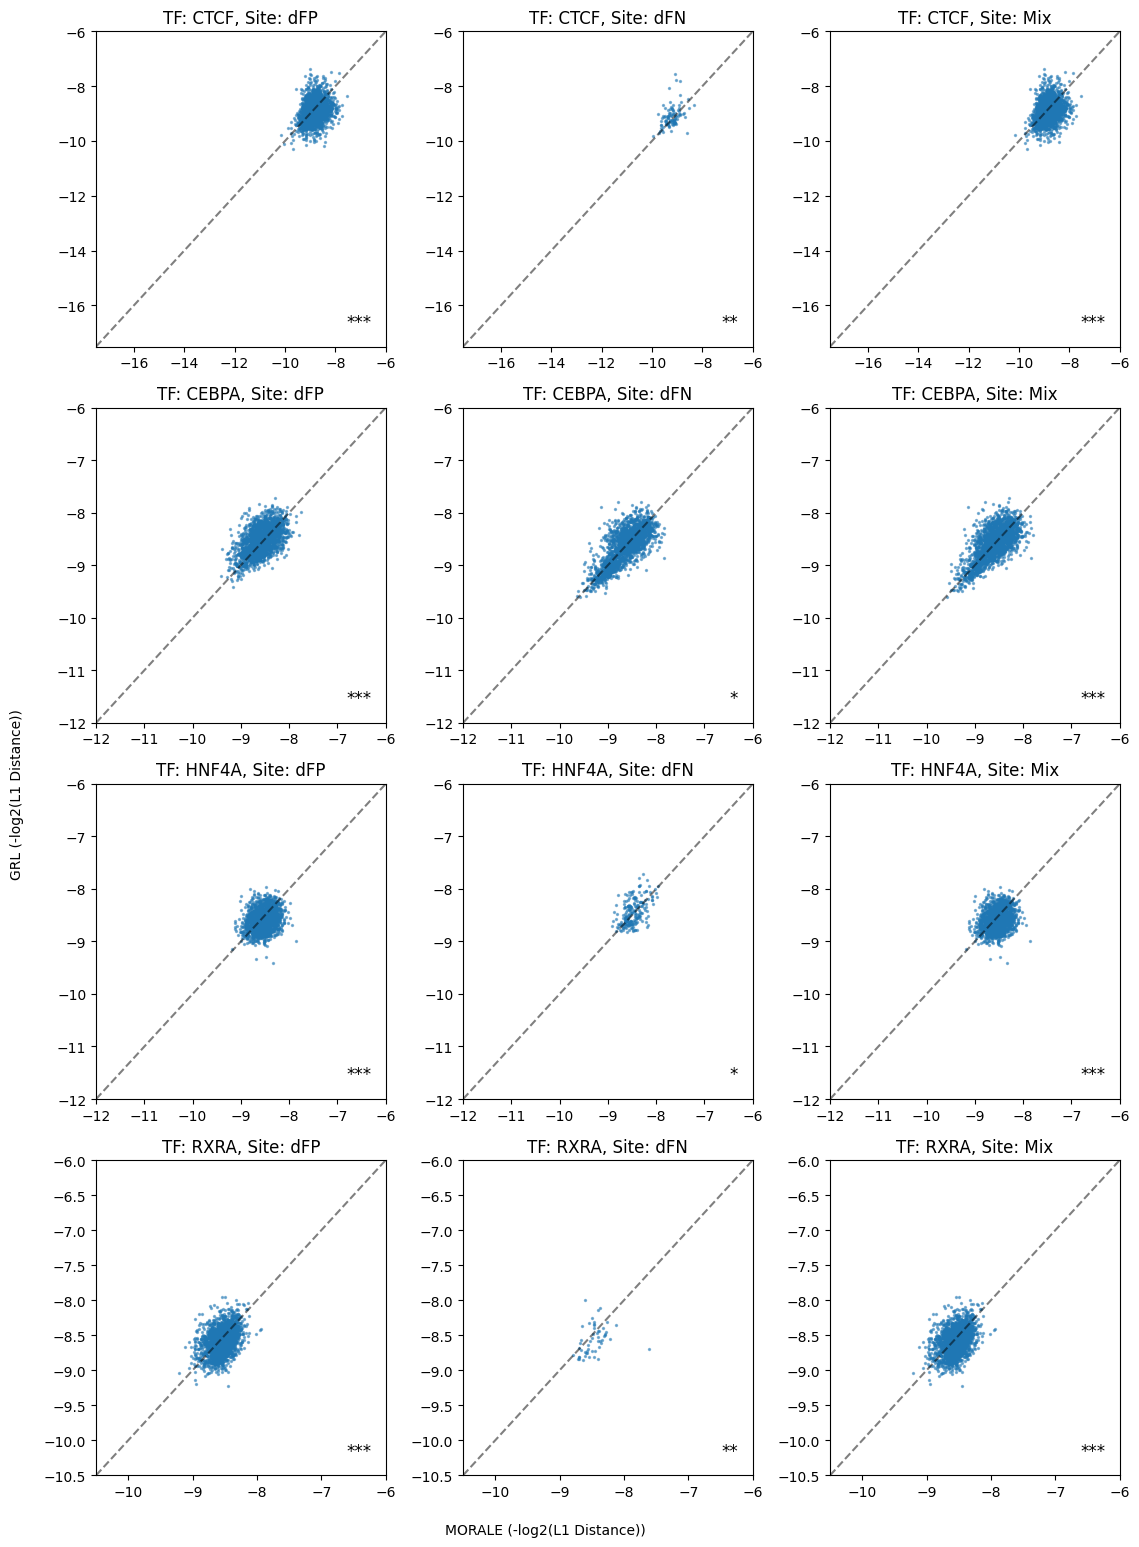

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import wilcoxon

# Create subplots: 4x3 grid
fig, axes = plt.subplots(4, 3, figsize=(12, 16))  # 4 rows, 3 columns
axes = axes.flatten()  # Flatten for easier indexing

# Create a dictionary to map site types to row indices
site_to_row = {site: i for i, site in enumerate(SITE_ORDER)}

plot_index = 0  # Keep track of the current subplot index
for tf_index, tf in enumerate(TFS):  # Iterate through TFs (columns)

    # Fix limits based on the transcription factor
    if tf == "CTCF":
        min_val = -17.5
        max_val = -6.0
    elif tf == "CEBPA":
        min_val = -12.0
        max_val = -6.0
    elif tf == "HNF4A":
        min_val = -12.0
        max_val = -6.0
    elif tf == "RXRA":
        min_val = -10.5
        max_val = -6.0
    
    for site_name in SITE_ORDER:
        ax = axes[plot_index]
        ax.set_title(f"TF: {tf}, Site: {site_name}")  # Title for each subplot
        plot_index += 1

        # Collect data for the current TF and site
        x_coords    = []    # MORALE values
        y_coords    = []    # GRL values
        # NO MORE p_values list, we have a single value now.
        if tf in distance_dict and site_name in distance_dict[tf]:
            tf_data = distance_dict[tf][site_name]
            min_len = min(len(tf_data["MORALE"]), len(tf_data["GRL"]))
            x_coords.extend(tf_data["MORALE"][:min_len])
            y_coords.extend(tf_data["GRL"][:min_len])
            # Get the single p-value.
            p_value = distance_dict[tf][site_name]['p_value']


        # Create the scatter plot
        ax.scatter(x_coords, y_coords, alpha=0.5, s=2)
        # ax.set_xlabel("MORALE")  # Removed for now, added globally later
        # ax.set_ylabel("GRL")     # Removed for now, added globally later

        # Add a 1:1 line
        # min_val = min(ax.get_xlim()[0], ax.get_ylim()[0], 0) #include zero
        # print(min_val)

        # max_val = max(ax.get_xlim()[1], ax.get_ylim()[1], 1) #include 1
        # print(max_val)

        # Add a 1:1 line
        ax.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.5)

        #set limits
        ax.set_xlim(min_val, max_val)
        ax.set_ylim(min_val, max_val)

        # Display single p-value as text
        if p_value < 0.001:
            sig_text = "***"
        elif p_value < 0.01:
            sig_text = "**"
        elif p_value < 0.05:
            sig_text = "*"
        else:
            sig_text = "ns"
        # Position the text.  Using a fraction of the axis range makes it
        # more consistent across different scales.
        ax.text(0.95, 0.05, sig_text, ha='right', va='bottom',
                transform=ax.transAxes,  # Use axis coordinates (0-1)
                color='black', fontsize=12)

# Add overall labels (optional)
fig.text(0.5, 0.04, 'MORALE (-log2(L1 Distance))', ha='center', va='center')
fig.text(0.06, 0.5, 'GRL (-log2(L1 Distance))', ha='center', va='center', rotation='vertical')

plt.tight_layout(rect=[0.07, 0.05, 1, 1])  # Adjust layout to make room for labels


if SAVE:
    print("Saving...")

    plt.savefig(
        f"{ROOT}/plots/Figure3/differential-l1-distances_{SPECIES1}-train_{SPECIES2}-test.pdf",
        dpi='figure',
        format='pdf',
        bbox_inches='tight',
        pad_inches=0.1
    )
else:
    plt.show()

## Comparing the pearson correlation

### Unweighted

In [ ]:
import random
from math import floor, ceil
from scipy.stats import pearsonr, wilcoxon

random.seed(42)

for source, target in [(SPECIES1, SPECIES2)]:

    all_scores_dict = np.load(f"{ROOT}/plots/Figure3/importance_train-{source}_test-{target}_scores.npy", allow_pickle=True).item()
    all_seqs_dict   = np.load(f"{ROOT}/plots/Figure3/importance_train-{source}_test-{target}_sequences.npy", allow_pickle=True).item()

    corr_dict = defaultdict(lambda : dict())

    for tf in TFS:
        for site_types in SITES_TO_PLOT:

            print(f"\n==== train: {source}, test: {target} on {tf}, {site_types} ====\n")
            
            # (0) Get the number of examples for whichever site type we are focusing on
            if (len(site_types) == 2):
                site_name   = "Mix"
                site_0_len  = len(read_holdout_bed(tf, SPECIES2, site_indices[tf][site_types[0]]))
                site_1_len  = len(read_holdout_bed(tf, SPECIES2, site_indices[tf][site_types[1]]))
                total_sites = site_0_len + site_1_len

                # Now we can recreate the mix based on the number of
                # predicted sites on the test set (Chr2)
                w_0       = site_0_len / total_sites
                w_1       = site_1_len / total_sites

                # Select a weighted amount of sites from each site type
                indices_0 = np.arange(len(all_scores_dict[tf][f'BM-{source}'][site_types[0]]))
                random.shuffle(indices_0)

                indices_0 = indices_0[:floor(len(indices_0) * w_0)]

                indices_1 = np.arange(len(all_scores_dict[tf][f'BM-{source}'][site_types[1]]))
                random.shuffle(indices_1)

                indices_1 = indices_1[:floor(len(indices_1) * w_1)]

                impt_morale_0  = all_scores_dict[tf][f'MORALE-{source}'][site_types[0]][indices_0, :]
                impt_morale_1  = all_scores_dict[tf][f'MORALE-{source}'][site_types[1]][indices_1, :]
                impt_morale    = np.concatenate([impt_morale_0, impt_morale_1])

                impt_grl_0     = all_scores_dict[tf][f'GRL-{source}'][site_types[0]][indices_0, :]
                impt_grl_1     = all_scores_dict[tf][f'GRL-{source}'][site_types[1]][indices_1, :]
                impt_grl       = np.concatenate([impt_grl_0, impt_grl_1])

                impt_target_0  = all_scores_dict[tf][f'BM-{target}'][site_types[0]][indices_0, :]
                impt_target_1  = all_scores_dict[tf][f'BM-{target}'][site_types[1]][indices_1, :]
                impt_target    = np.concatenate([impt_target_0, impt_target_1])
            else:
                site_name = site_types
                impt_morale = all_scores_dict[tf][f'MORALE-{source}'][site_types]
                impt_grl    = all_scores_dict[tf][f'GRL-{source}'][site_types]
                impt_target = all_scores_dict[tf][f'BM-{target}'][site_types]

            # Average over the channel dimension
            impt_morale = np.mean(impt_morale, axis=1)
            impt_grl    = np.mean(impt_grl, axis=1)
            impt_target = np.mean(impt_target, axis=1)

            # Calculate Distance from Ground Truth
            correlations_morale = pearsonr(x=impt_target, y=impt_morale, alternative='greater', axis=1)[0]
            correlations_grl    = pearsonr(x=impt_target, y=impt_grl, alternative='greater', axis=1)[0]

            statistic_l1, corr_pval = wilcoxon(
                correlations_morale,
                correlations_grl,
                zero_method='wilcox',
                alternative='two-sided'  # Explicitly set options
            )

            corr_dict[tf][site_name] = {"MORALE": correlations_morale, "GRL": correlations_grl, "p_value": corr_pval}


==== train: mm10, test: hg38 on CTCF, dFP ====

(2000,) (2000,)

==== train: mm10, test: hg38 on CTCF, dFN ====

(973,) (973,)

==== train: mm10, test: hg38 on CTCF, ['dFP', 'dFN'] ====

(1663,) (1663,)

==== train: mm10, test: hg38 on CEBPA, dFP ====

(2000,) (2000,)

==== train: mm10, test: hg38 on CEBPA, dFN ====

(12,) (12,)

==== train: mm10, test: hg38 on CEBPA, ['dFP', 'dFN'] ====

(1988,) (1988,)

==== train: mm10, test: hg38 on HNF4A, dFP ====

(2000,) (2000,)

==== train: mm10, test: hg38 on HNF4A, dFN ====

(863,) (863,)

==== train: mm10, test: hg38 on HNF4A, ['dFP', 'dFN'] ====

(1657,) (1657,)

==== train: mm10, test: hg38 on RXRA, dFP ====

(2000,) (2000,)

==== train: mm10, test: hg38 on RXRA, dFN ====

(2000,) (2000,)

==== train: mm10, test: hg38 on RXRA, ['dFP', 'dFN'] ====

(2000,) (2000,)


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import wilcoxon

# Create subplots: 4x3 grid
fig, axes = plt.subplots(4, 3, figsize=(12, 16))  # 4 rows, 3 columns
axes = axes.flatten()  # Flatten for easier indexing

# Create a dictionary to map site types to row indices
site_to_row = {site: i for i, site in enumerate(SITE_ORDER)}

plot_index = 0  # Keep track of the current subplot index
for tf_index, tf in enumerate(TFS):  # Iterate through TFs (columns)

    # Fix limits based on the transcription factor
    if tf == "CTCF":
        min_val = 0.0
        max_val = 1.05
    elif tf == "CEBPA":
        min_val = 0.0
        max_val = 1.05
    elif tf == "HNF4A":
        min_val = 0.0
        max_val = 1.05
    elif tf == "RXRA":
        min_val = 0.0
        max_val = 1.05
    
    for site_name in SITE_ORDER:
        ax = axes[plot_index]
        ax.set_title(f"TF: {tf}, Site: {site_name}")  # Title for each subplot
        plot_index += 1

        # Collect data for the current TF and site
        x_coords    = []    # MORALE values
        y_coords    = []    # GRL values
        # NO MORE p_values list, we have a single value now.
        if tf in corr_dict and site_name in corr_dict[tf]:
            tf_data = corr_dict[tf][site_name]
            min_len = min(len(tf_data["MORALE"]), len(tf_data["GRL"]))
            x_coords.extend(tf_data["MORALE"][:min_len])
            y_coords.extend(tf_data["GRL"][:min_len])
            # Get the single p-value.
            p_value = corr_dict[tf][site_name]['p_value']


        # Create the scatter plot
        ax.scatter(x_coords, y_coords, alpha=0.5, s=2)
        # ax.set_xlabel("MORALE")  # Removed for now, added globally later
        # ax.set_ylabel("GRL")     # Removed for now, added globally later

        # Add a 1:1 line
        # min_val = min(ax.get_xlim()[0], ax.get_ylim()[0], 0) #include zero
        # print(min_val)

        # max_val = max(ax.get_xlim()[1], ax.get_ylim()[1], 1) #include 1
        # print(max_val)

        # Add a 1:1 line
        ax.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.5)

        #set limits
        ax.set_xlim(min_val, max_val)
        ax.set_ylim(min_val, max_val)

        # Display single p-value as text
        if p_value < 0.001:
            sig_text = "***"
        elif p_value < 0.01:
            sig_text = "**"
        elif p_value < 0.05:
            sig_text = "*"
        else:
            sig_text = "ns"
        # Position the text.  Using a fraction of the axis range makes it
        # more consistent across different scales.
        ax.text(0.95, 0.05, sig_text, ha='right', va='bottom',
                transform=ax.transAxes,  # Use axis coordinates (0-1)
                color='black', fontsize=12)


# Add overall labels (optional)
fig.text(0.5, 0.04, 'MORALE (Pearson correlation coefficient)', ha='center', va='center')
fig.text(0.06, 0.5, 'GRL (Pearson correlation coefficient)', ha='center', va='center', rotation='vertical')

plt.tight_layout(rect=[0.07, 0.05, 1, 1])  # Adjust layout to make room for labels
# plt.show()

if SAVE:
    print("Saving...")

    plt.savefig(
        f"{ROOT}/plots/Figure3-1/differential-correlations_{SPECIES1}-train_{SPECIES2}-test.svg",
        transparent=True,
        dpi='figure',
        format='svg',
        bbox_inches='tight',
        pad_inches=0.1
    )

Saving...


### Weighted

In [20]:
import random
from math import floor, ceil
from scipy.stats import pearsonr, wilcoxon

random.seed(42)

def weighted_pearsonr(x, y, z):
    """
    Calculate weighted Pearson correlation coefficient
    If weights is None, falls back to regular Pearson correlation
    """
    assert len(x.shape) == 1 and  len(y.shape) == 1 and  len(z.shape) == 1, "Input vectors must have the same shape"
    
    # Ensure weights are non-negative and based on target importance
    weights = np.abs(z)
    
    # Weighted means
    wx = np.average(x, weights=weights)
    wy = np.average(y, weights=weights)
    
    # Weighted covariance and variances
    cov_xy = np.average((x - wx) * (y - wy), weights=weights)
    var_x = np.average((x - wx)**2, weights=weights)
    var_y = np.average((y - wy)**2, weights=weights)
    
    # Correlation coefficient
    if var_x == 0 or var_y == 0:
        return 0.0  # Avoid division by zero
    return cov_xy / np.sqrt(var_x * var_y)

def row_wise_weighted_pearsonr(x, y, z):
    """
    Applies the weighted_pearsonr function row-wise to matrices x, y, and z.

    Args:
        x: A 2D NumPy array of shape (num_samples, num_features).
        y: A 2D NumPy array of shape (num_samples, num_features).
        z: A 2D NumPy array of shape (num_samples, num_features).

    Returns:
        A 1D NumPy array of shape (num_samples,) containing the weighted
        Pearson correlation coefficient for each sample (row).

    Raises:
      ValueError: if shapes are not compatible.
      Any Exception raised by weighted_pearsonr
    """
    if not (x.shape == y.shape == z.shape):
        raise ValueError("Input matrices must have the same shape.")
    if x.ndim != 2:
        raise ValueError("Input matrices must be 2-dimensional.")

    num_samples = x.shape[0]
    correlations = np.zeros(num_samples)

    for i in range(num_samples):
        try:
            correlations[i] = weighted_pearsonr(x[i, :], y[i, :], z[i, :])
        except (AssertionError, TypeError) as e:
             raise e # or, for example: correlations[i] = np.nan

    return correlations

for source, target in [(SPECIES1, SPECIES2)]:

    all_scores_dict = np.load(f"{ROOT}/plots/Figure3/importance_train-{source}_test-{target}_scores.npy", allow_pickle=True).item()
    all_seqs_dict   = np.load(f"{ROOT}/plots/Figure3/importance_train-{source}_test-{target}_sequences.npy", allow_pickle=True).item()

    corr_dict = defaultdict(lambda : dict())

    for tf in TFS:
        for site_types in SITES_TO_PLOT:

            print(f"\n==== train: {source}, test: {target} on {tf}, {site_types} ====\n")
            
            # (0) Get the number of examples for whichever site type we are focusing on
            if (len(site_types) == 2):
                site_name   = "Mix"
                site_0_len  = len(read_holdout_bed(tf, SPECIES2, site_indices[tf][site_types[0]]))
                site_1_len  = len(read_holdout_bed(tf, SPECIES2, site_indices[tf][site_types[1]]))
                total_sites = site_0_len + site_1_len

                # Now we can recreate the mix based on the number of
                # predicted sites on the test set (Chr2)
                w_0       = site_0_len / total_sites
                w_1       = site_1_len / total_sites

                # Select a weighted amount of sites from each site type
                indices_0 = np.arange(len(all_scores_dict[tf][f'BM-{source}'][site_types[0]]))
                random.shuffle(indices_0)

                indices_0 = indices_0[:floor(len(indices_0) * w_0)]

                indices_1 = np.arange(len(all_scores_dict[tf][f'BM-{source}'][site_types[1]]))
                random.shuffle(indices_1)

                indices_1 = indices_1[:floor(len(indices_1) * w_1)]

                impt_morale_0  = all_scores_dict[tf][f'MORALE-{source}'][site_types[0]][indices_0, :]
                impt_morale_1  = all_scores_dict[tf][f'MORALE-{source}'][site_types[1]][indices_1, :]
                impt_morale    = np.concatenate([impt_morale_0, impt_morale_1])

                impt_grl_0     = all_scores_dict[tf][f'GRL-{source}'][site_types[0]][indices_0, :]
                impt_grl_1     = all_scores_dict[tf][f'GRL-{source}'][site_types[1]][indices_1, :]
                impt_grl       = np.concatenate([impt_grl_0, impt_grl_1])

                impt_target_0  = all_scores_dict[tf][f'BM-{target}'][site_types[0]][indices_0, :]
                impt_target_1  = all_scores_dict[tf][f'BM-{target}'][site_types[1]][indices_1, :]
                impt_target    = np.concatenate([impt_target_0, impt_target_1])
            else:
                site_name = site_types
                impt_morale = all_scores_dict[tf][f'MORALE-{source}'][site_types]
                impt_grl    = all_scores_dict[tf][f'GRL-{source}'][site_types]
                impt_target = all_scores_dict[tf][f'BM-{target}'][site_types]

            # Average over the channel dimension
            impt_morale = np.mean(impt_morale, axis=1)
            impt_grl    = np.mean(impt_grl, axis=1)
            impt_target = np.mean(impt_target, axis=1)

            # Calculated weighted correlation based on target importance
            correlations_grl    = row_wise_weighted_pearsonr(impt_target, impt_grl, impt_target)
            correlations_morale = row_wise_weighted_pearsonr(impt_target, impt_morale, impt_target)

            statistic_l1, corr_pval = wilcoxon(
                correlations_morale,
                correlations_grl,
                zero_method='wilcox',
                alternative='two-sided'  # Explicitly set options
            )

            corr_dict[tf][site_name] = {"MORALE": correlations_morale, "GRL": correlations_grl, "p_value": corr_pval}


==== train: mm10, test: hg38 on CTCF, dFP ====


==== train: mm10, test: hg38 on CTCF, dFN ====


==== train: mm10, test: hg38 on CTCF, ['dFP', 'dFN'] ====


==== train: mm10, test: hg38 on CEBPA, dFP ====


==== train: mm10, test: hg38 on CEBPA, dFN ====


==== train: mm10, test: hg38 on CEBPA, ['dFP', 'dFN'] ====


==== train: mm10, test: hg38 on HNF4A, dFP ====


==== train: mm10, test: hg38 on HNF4A, dFN ====


==== train: mm10, test: hg38 on HNF4A, ['dFP', 'dFN'] ====


==== train: mm10, test: hg38 on RXRA, dFP ====


==== train: mm10, test: hg38 on RXRA, dFN ====


==== train: mm10, test: hg38 on RXRA, ['dFP', 'dFN'] ====



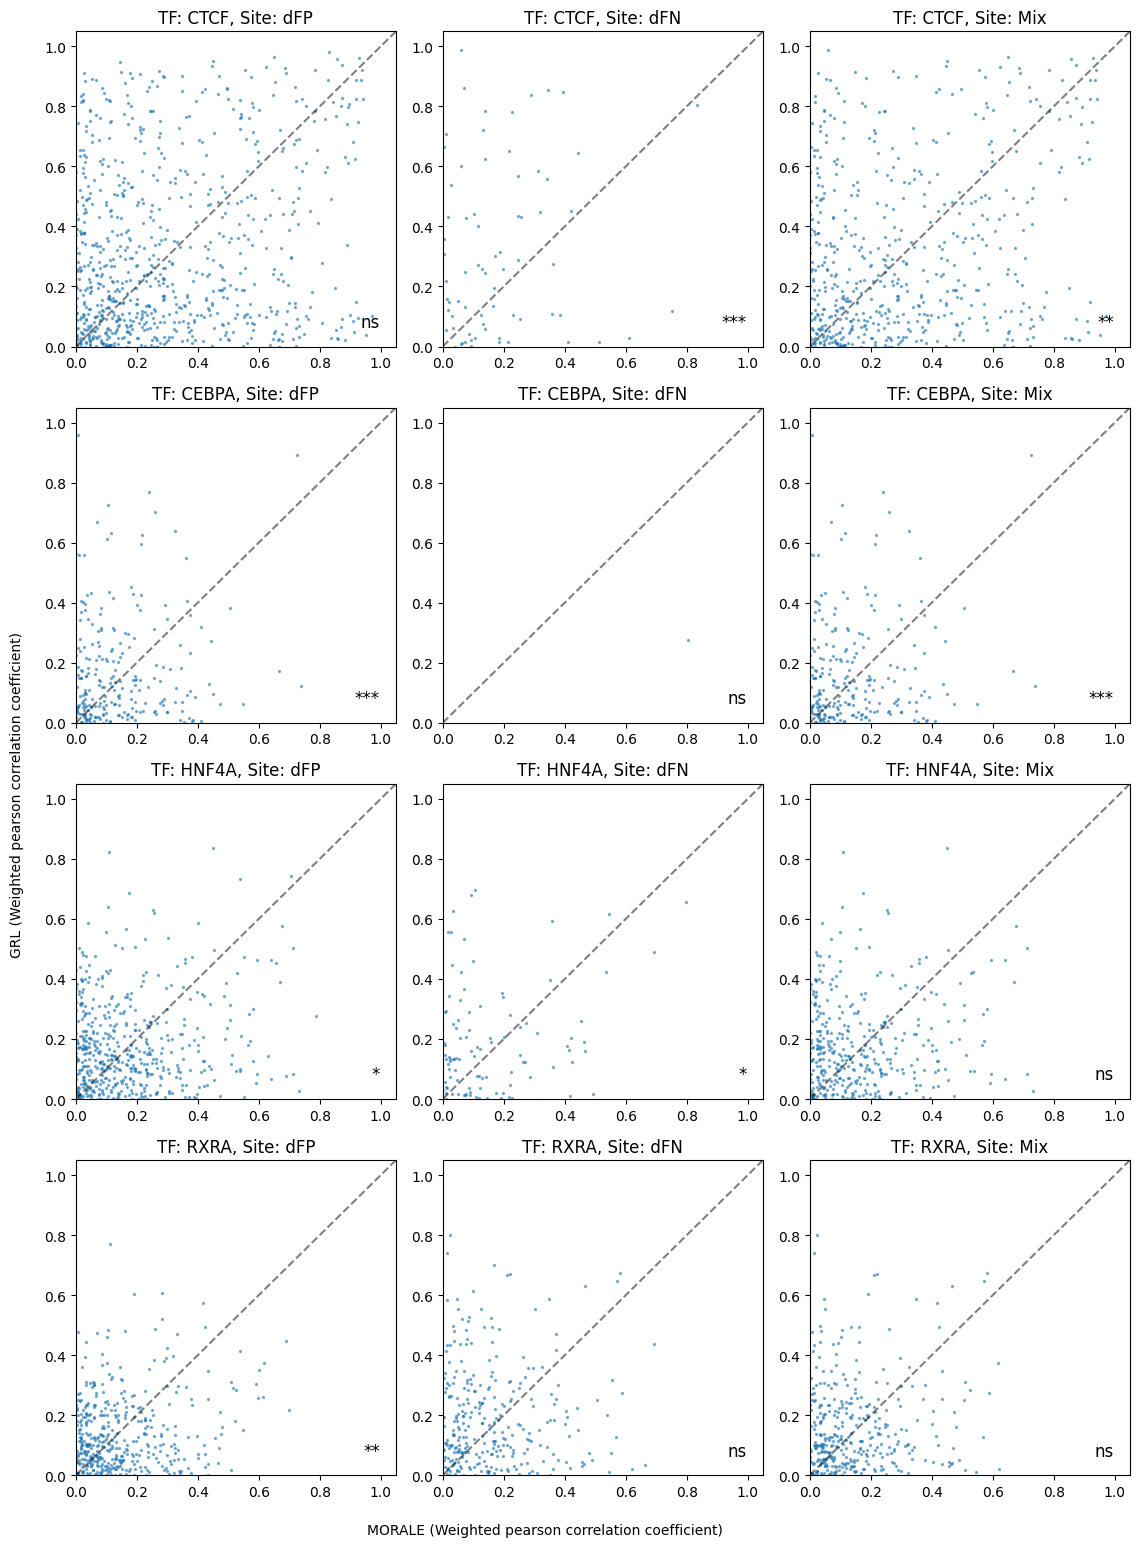

In [21]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import wilcoxon

# Create subplots: 4x3 grid
fig, axes = plt.subplots(4, 3, figsize=(12, 16))  # 4 rows, 3 columns
axes = axes.flatten()  # Flatten for easier indexing

# Create a dictionary to map site types to row indices
site_to_row = {site: i for i, site in enumerate(SITE_ORDER)}

plot_index = 0  # Keep track of the current subplot index
for tf_index, tf in enumerate(TFS):  # Iterate through TFs (columns)

    # Fix limits based on the transcription factor
    if tf == "CTCF":
        min_val = 0.0
        max_val = 1.05
    elif tf == "CEBPA":
        min_val = 0.0
        max_val = 1.05
    elif tf == "HNF4A":
        min_val = 0.0
        max_val = 1.05
    elif tf == "RXRA":
        min_val = 0.0
        max_val = 1.05
    
    for site_name in SITE_ORDER:
        ax = axes[plot_index]
        ax.set_title(f"TF: {tf}, Site: {site_name}")  # Title for each subplot
        plot_index += 1

        # Collect data for the current TF and site
        x_coords    = []    # MORALE values
        y_coords    = []    # GRL values
        # NO MORE p_values list, we have a single value now.
        if tf in corr_dict and site_name in corr_dict[tf]:
            tf_data = corr_dict[tf][site_name]
            min_len = min(len(tf_data["MORALE"]), len(tf_data["GRL"]))
            x_coords.extend(tf_data["MORALE"][:min_len])
            y_coords.extend(tf_data["GRL"][:min_len])
            # Get the single p-value.
            p_value = corr_dict[tf][site_name]['p_value']


        # Create the scatter plot
        ax.scatter(x_coords, y_coords, alpha=0.5, s=2)
        # ax.set_xlabel("MORALE")  # Removed for now, added globally later
        # ax.set_ylabel("GRL")     # Removed for now, added globally later

        # Add a 1:1 line
        # min_val = min(ax.get_xlim()[0], ax.get_ylim()[0], 0) #include zero
        # print(min_val)

        # max_val = max(ax.get_xlim()[1], ax.get_ylim()[1], 1) #include 1
        # print(max_val)

        # Add a 1:1 line
        ax.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.5)

        #set limits
        ax.set_xlim(min_val, max_val)
        ax.set_ylim(min_val, max_val)

        # Display single p-value as text
        if p_value < 0.001:
            sig_text = "***"
        elif p_value < 0.01:
            sig_text = "**"
        elif p_value < 0.05:
            sig_text = "*"
        else:
            sig_text = "ns"
        # Position the text.  Using a fraction of the axis range makes it
        # more consistent across different scales.
        ax.text(0.95, 0.05, sig_text, ha='right', va='bottom',
                transform=ax.transAxes,  # Use axis coordinates (0-1)
                color='black', fontsize=12)


# Add overall labels (optional)
fig.text(0.5, 0.04, 'MORALE (Weighted pearson correlation coefficient)', ha='center', va='center')
fig.text(0.06, 0.5, 'GRL (Weighted pearson correlation coefficient)', ha='center', va='center', rotation='vertical')

plt.tight_layout(rect=[0.07, 0.05, 1, 1])  # Adjust layout to make room for labels
plt.show()

# if SAVE:
#     print("Saving...")

#     plt.savefig(
#         f"{ROOT}/plots/Figure3-1/differential-correlations_{SPECIES1}-train_{SPECIES2}-test.svg",
#         transparent=True,
#         dpi='figure',
#         format='svg',
#         bbox_inches='tight',
#         pad_inches=0.1
#     )

---